In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os


os.environ["TOKENIZERS_PARALLELISM"] = "false"


import safe as sf
import datamol as dm


Load the default pretrained Safe model.

We will use this unique model for all the downstream molecular design tasks.


In [3]:
designer = sf.SAFEDesign.load_default(verbose=True)

designer.model


SAFEDoubleHeadsModel(
  (transformer): GPT2Model(
    (wte): Embedding(1880, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=1880, bias=False)
  (multiple_choice_head): PropertyHead(
    (summary): Linear(in_features=768, out_features=64, bias=True)
    

Let's start with the below molecule.


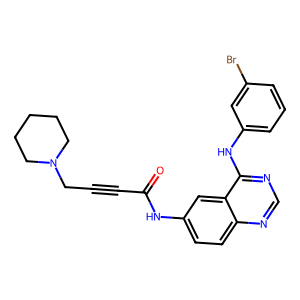

In [4]:
candidate_smiles = "O=C(C#CCN1CCCCC1)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1"
candidate_mol = dm.to_mol(candidate_smiles)

dm.to_image(candidate_mol)


## De novo generation

Generation of novel molecules without any constraints.


In [6]:
generated_smiles = designer.de_novo_generation(sanitize=True, n_samples_per_trial=12)

generated_smiles[:5]


  0%|          | 0/1 [00:00<?, ?it/s]

/home/hadim/local/micromamba/envs/safe/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
2023-10-28 11:37:25.393 | INFO     | safe.sample:de_novo_generation:581 - After sanitization, 82 / 100 (82.00 %) generated molecules are valid !


['CCCCOc1c(Br)cc(C)cc1-c1nc(C2(CC)CCN(C(C)C)CC2)cn2nc(C)nc12',
 'CC(C)(C)OC(=O)Nc1ccc(C[NH+]2CC[C@@H]3OCCC[C@H]3C2)cn1',
 'Cc1ccc(Br)c(NCCC(C)C(C)C)c1',
 'CCOC(=O)C1=C(C)N=c2s/c(=C/c3c(C)[nH]c4ccccc34)c(=O)n2[C@@H]1c1ccc(OC)cc1',
 'CCc1ccccc1-n1cc(O)c(C(=O)Nc2ccc(Cl)c(F)c2)n1']

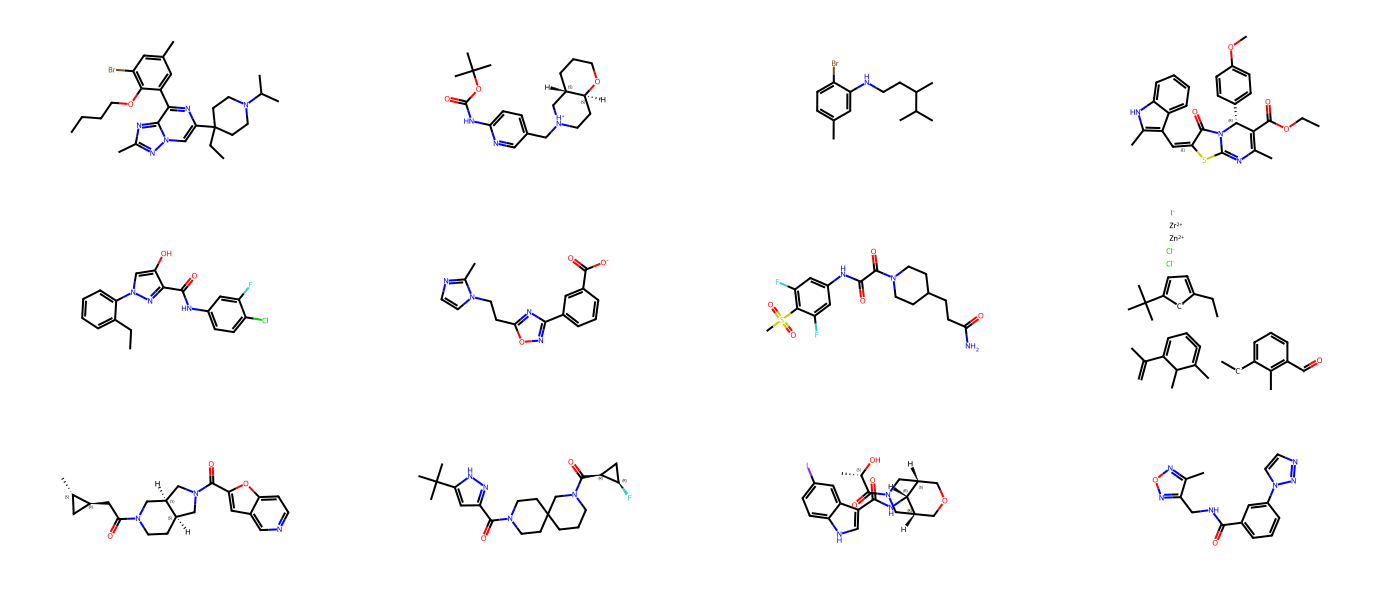

In [7]:
dm.to_image(generated_smiles[:12], mol_size=(350, 200))


## Scaffold Decoration

For scaffold decoration, we wish to generate new molecules that would contain a given scaffold as core. Usually, the attachment point on the scaffold should dictate where the new vectors will be added.


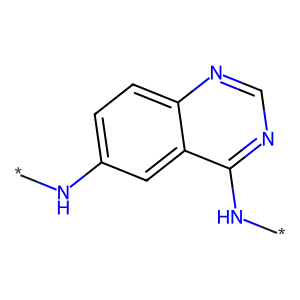

In [8]:
scaffold = "[*]N-c1ccc2ncnc(-N[*])c2c1"

dm.to_image(scaffold)


In [9]:
generated_smiles = designer.scaffold_decoration(
    scaffold=scaffold,
    n_samples_per_trial=12,
    n_trials=2,
    sanitize=True,
    do_not_fragment_further=True,
)

generated_mols = [dm.to_mol(x) for x in generated_smiles]


  0%|          | 0/2 [00:00<?, ?it/s]

/home/hadim/local/micromamba/envs/safe/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
2023-10-28 11:37:48.620 | INFO     | safe.sample:scaffold_decoration:542 - After sanitization, 21 / 24 (87.50 %)  generated molecules are valid !


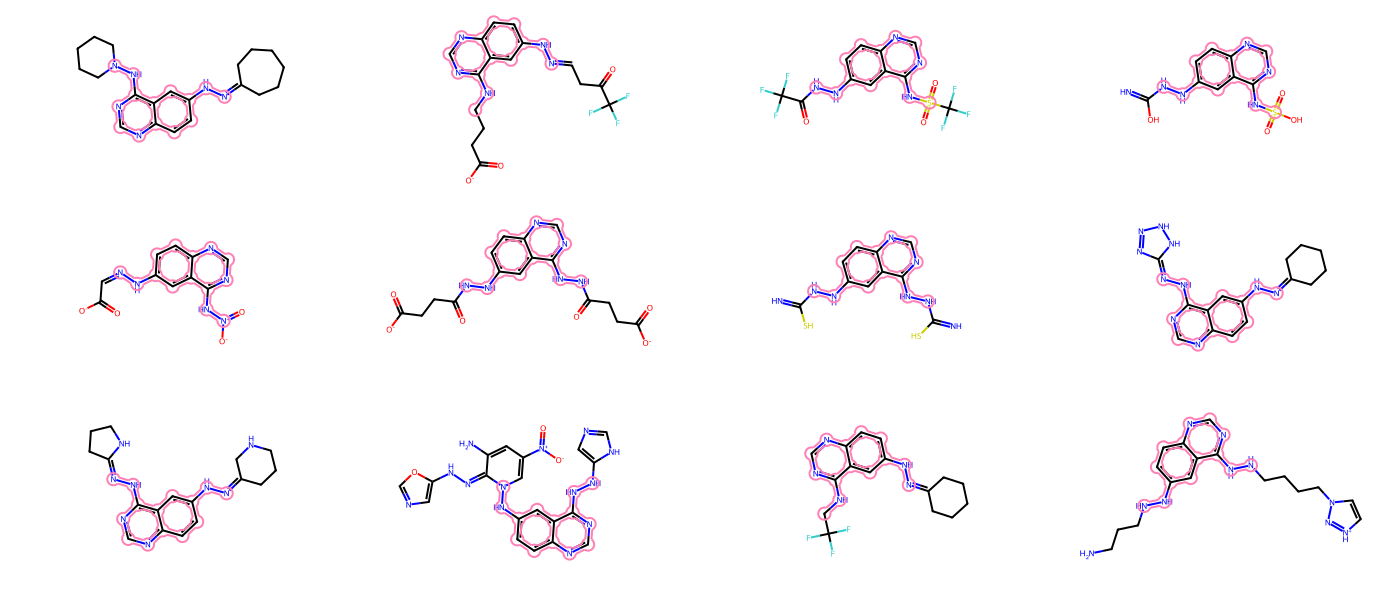

In [10]:
dm.viz.lasso_highlight_image(generated_mols[:12], dm.from_smarts(scaffold), mol_size=(350, 200), color_list=["#ff80b5"], scale_padding=0.1)


## Super structure generation

In super structure generation, we just want to generate superstructure of a molecular subgraph


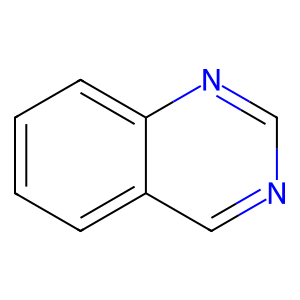

In [11]:
superstructure = "c1ccc2ncncc2c1"

dm.to_image(superstructure)


In [12]:
generated_smiles = designer.super_structure(
    core=superstructure,
    n_samples_per_trial=12,
    n_trials=1,
    sanitize=True,
    do_not_fragment_further=False,
    attachment_point_depth=3,
)

generated_smiles


  0%|          | 0/1 [00:00<?, ?it/s]

/home/hadim/local/micromamba/envs/safe/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
2023-10-28 11:38:24.884 | INFO     | safe.sample:super_structure:496 - After sanitization, 12 / 12 (100.00 %)  generated molecules are valid !


['c1ncc2c(N3CCOCC3)ccc(N3CCNCC3)c2n1',
 'N[C@H](CNc1ccc(C(F)(F)F)c2ncncc12)C(F)(F)F',
 'C=CCCCNC(=S)Nc1ccc(C(F)(F)F)c2cncnc12',
 'O=C(N[C@@H](CO)CCF)c1ccc(C(=O)[O-])c2ncncc12',
 'O=C(CC=Nc1ccc(OC(F)(F)F)c2ncncc12)C(F)(F)F',
 'NC(=Nc1ccc([N+](=O)[O-])c2cncnc12)C(F)(F)F',
 'O=C(CCC(F)=C(F)F)Nc1ccc(C(F)(F)F)c2ncncc12',
 'O=S(=O)(CCC(F)(F)F)Nc1cccc2cncnc12',
 'O=S(=O)(Cl)c1ccc(C(F)(F)F)c2ncncc12',
 'c1ncc2c(N3CCCCCC3)ccc(-c3cn[nH]c3)c2n1',
 'NC(=O)CSCC(=O)Nc1ccc(C(=O)[O-])c2ncncc12',
 'c1ncc2c(-n3cncn3)ccc(C3CCCCN3)c2n1']

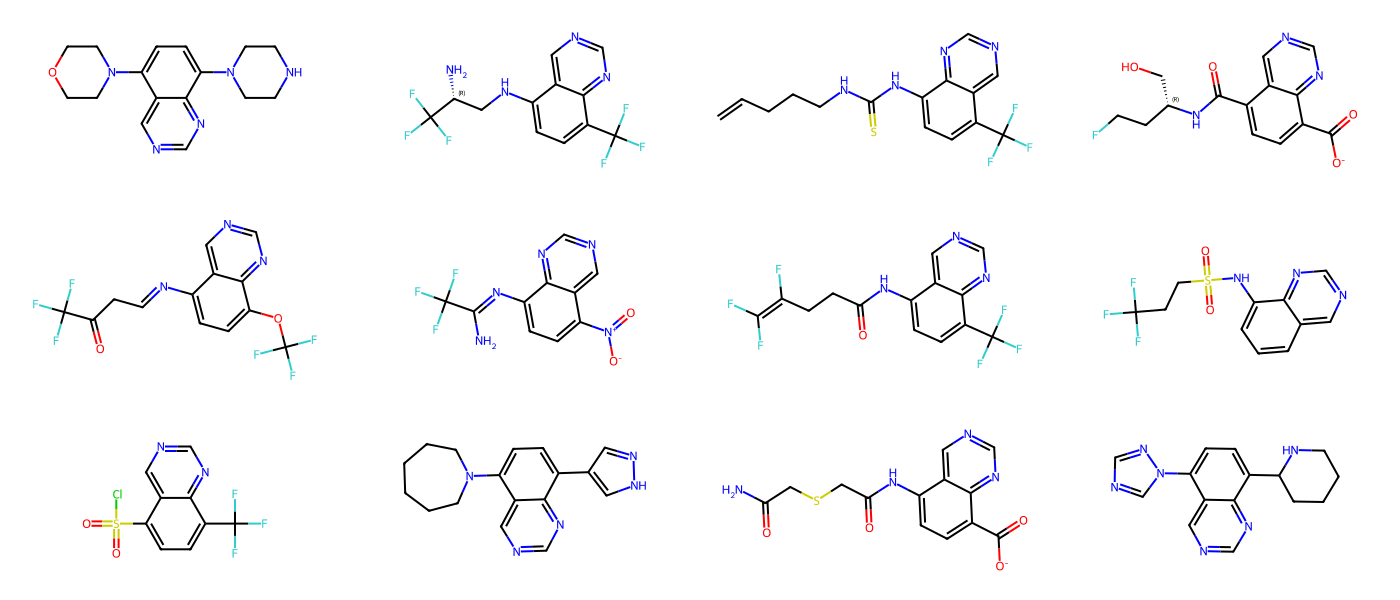

In [14]:
dm.to_image(generated_smiles[:12], mol_size=(350, 200))


## Motif Extension

In motif extension, we are interested in generating a molecule containing a given motif as starting point.


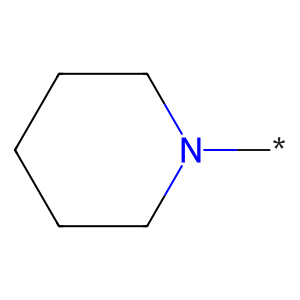

In [15]:
motif = "[*]-N1CCCCC1"

dm.to_image(motif)


In [26]:
# let's make some long sequence
generated_smiles = designer.motif_extension(
    motif=motif,
    n_samples_per_trial=12,
    n_trials=1,
    sanitize=True,
    do_not_fragment_further=False,
    min_length=25,
    max_length=80,
)

generated_smiles


  0%|          | 0/1 [00:00<?, ?it/s]

2023-10-28 11:41:52.959 | INFO     | safe.sample:scaffold_decoration:542 - After sanitization, 10 / 12 (83.33 %)  generated molecules are valid !


['C1CCN([C@@H]2CCCC[C@@H]2[NH+]2CCOCC2)CC1',
 'FC(F)(F)C(F)(F)CN1CCCCC1',
 'O=NN(/C(=C/N1CCCCC1)N1CCCCC1)c1ccccc1',
 'C1CCC(CC2(CC3CCCC3)CCCCC2C2CCCCCC2N2CCCCC2)CC1',
 '[Na+].[Na+].[O-]S(=S)(=S)N1CCCCC1',
 'NC(CS)C(O)=NC(O)C(=O)N1CCCCC1',
 'O=P(O)(O)CCOCCOP(=O)(O)SCCN1CCCCC1',
 'C1CCN(N=c2nn[nH][nH]2)CC1.O.O',
 'N.N#CC1C=CCN1N1CCCCC1',
 'O=C1CCCCC1.O=C1COCCCN1N1CCCCC1']

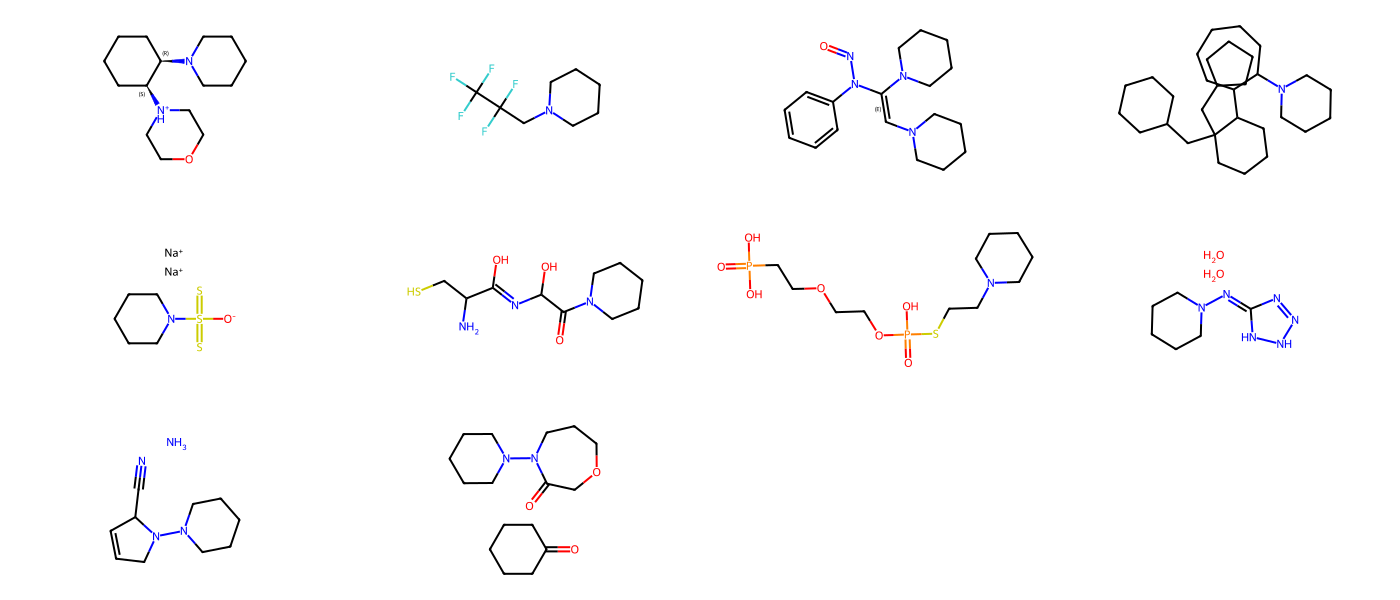

In [27]:
dm.to_image(generated_smiles[:12], mol_size=(350, 200))


## Scaffold Morphing

In scaffold morphing, we wish to replace a scaffold by another one in a molecule. The process requires as input that the user provides either the side chains or the input molecules and the core


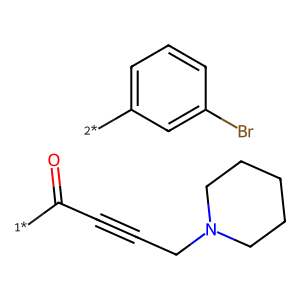

In [28]:
side_chains = "[1*]C(=O)C#CCN1CCCCC1.[2*]c1cccc(Br)c1"

dm.to_image(side_chains)


  0%|          | 0/1 [00:00<?, ?it/s]

2023-10-28 11:42:05.888 | INFO     | safe.sample:_fragment_linking:397 - After sanitization, 12 / 12 (100.00 %)  generated molecules are valid !


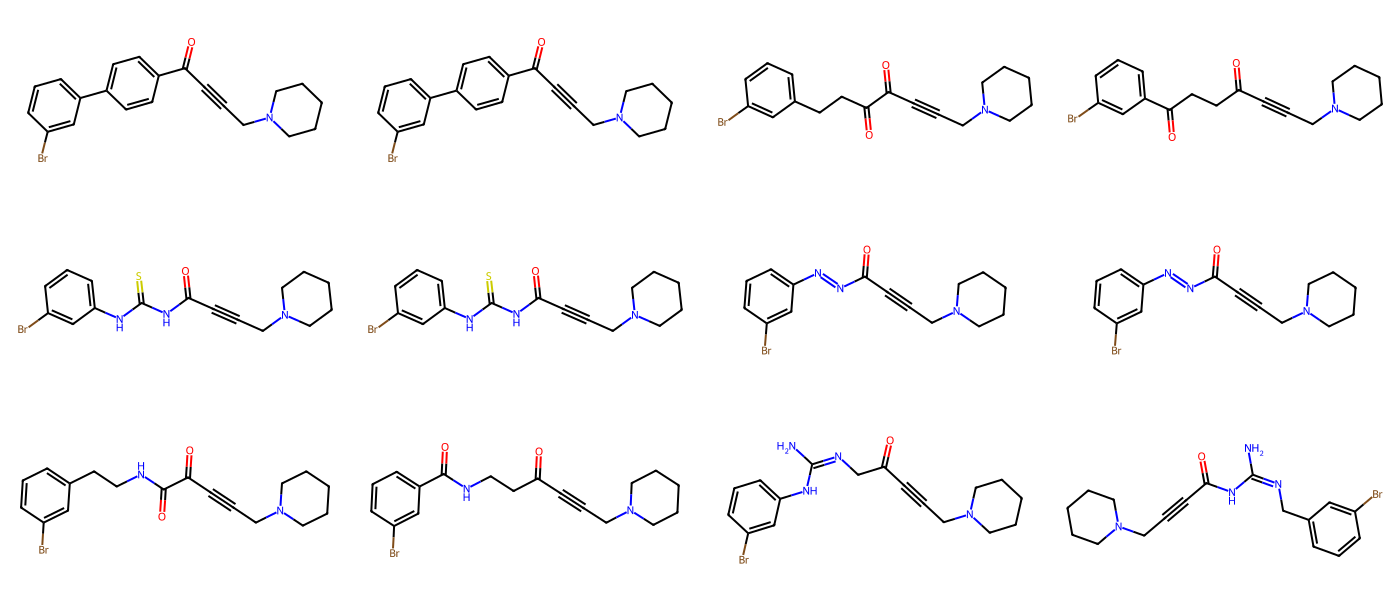

In [29]:
generated_smiles = designer.scaffold_morphing(
    side_chains=side_chains,
    n_samples_per_trial=12,
    n_trials=1,
    sanitize=True,
    do_not_fragment_further=False,
    random_seed=100,
)

dm.to_image(generated_smiles[:12], mol_size=(350, 200))


## Linker generation

Linker generation is mostly the same thing as scaffold morphing ...


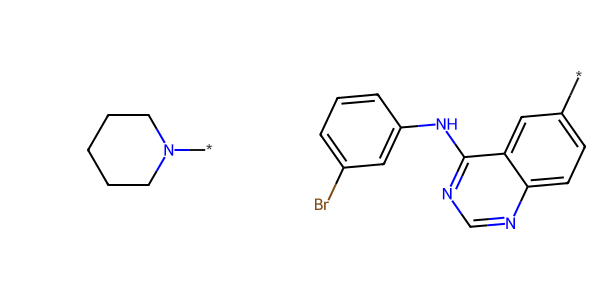

In [30]:
linker_generation = ["[*]-N1CCCCC1", "Brc1cccc(Nc2ncnc3ccc(-[*])cc23)c1"]

dm.to_image(linker_generation)


In [31]:
generated_smiles = designer.linker_generation(
    *linker_generation,
    n_samples_per_trial=12,
    n_trials=1,
    sanitize=True,
    do_not_fragment_further=False,
    random_seed=100,
)

generated_smiles


  0%|          | 0/1 [00:00<?, ?it/s]

2023-10-28 11:42:14.034 | INFO     | safe.sample:_fragment_linking:397 - After sanitization, 12 / 12 (100.00 %)  generated molecules are valid !


['O=C(Oc1cccc(-c2nc(N3CCCCC3)nc3c2CCN3)c1)c1ccc2ncnc(Nc3cccc(Br)c3)c2c1',
 'O=C(Oc1cccc(-c2nc(-c3ccc4ncnc(Nc5cccc(Br)c5)c4c3)nc3c2CCN3)c1)N1CCCCC1',
 'N=C(N)NCCCN1C(=O)N(CN2CCCCC2)C(=O)C2CC(c3ccc4ncnc(Nc5cccc(Br)c5)c4c3)CC21',
 'N=C(N)NCCCN1C(=O)N(Cc2ccc3ncnc(Nc4cccc(Br)c4)c3c2)C(=O)C2CC(N3CCCCC3)CC21',
 'Brc1cccc(Nc2ncnc3ccc(-c4cccc5c4oc4c6ccccc6c(Nc6cccc(N7CCCCC7)c6)cc54)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(-c4cccc(Nc5cc6c7cccc(N8CCCCC8)c7oc6c6ccccc56)c4)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(-c4cc(-c5nc6n(n5)CC=C[C@H]6N5CCCCC5)ncn4)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc([C@@H]4C=CCn5nc(-c6cc(N7CCCCC7)ncn6)nc54)cc23)c1',
 'O=C1C[C@@H]2C[C@H]3[C@H](N4CCCCC4)CC4COCCC42O[C@@H]3CC(CCc2ccc3ncnc(Nc4cccc(Br)c4)c3c2)O1',
 'O=C1C[C@@H]2C[C@@H]3[C@@H](CC(CCN4CCCCC4)O1)OC21CCOCC1C[C@H]3c1ccc2ncnc(Nc3cccc(Br)c3)c2c1',
 'Brc1cccc(Nc2ncnc3ccc(NNc4ccc(SCCCCCCc5ccc(N6CCCCC6)cc5)cc4)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(-c4ccc(CCCCCCSc5ccc(NNN6CCCCC6)cc5)cc4)cc23)c1']

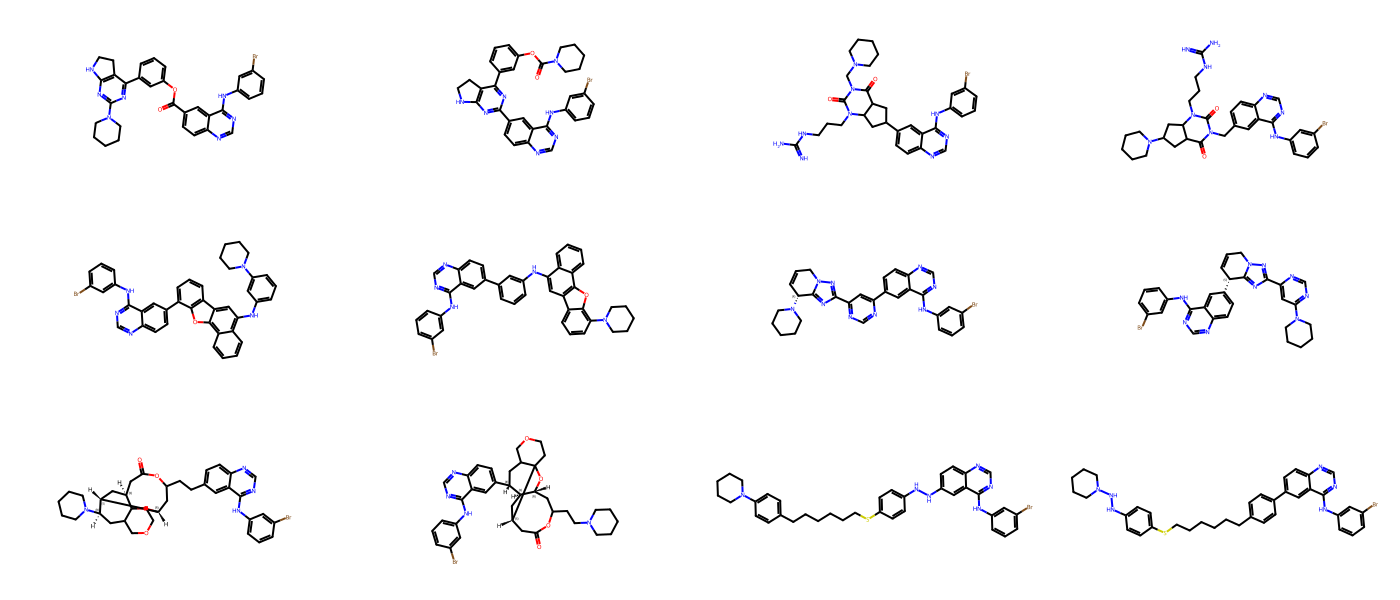

In [32]:
dm.to_image(generated_smiles[:12], mol_size=(350, 200))


---

The End !